# Word embeddings

In [1]:
import numpy as np
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

# Computation of Word Embeddings

## Toy corpus

In [2]:
corpus = [
    'she queen',
    'she woman',
    'he king',
    'he man',
    'london uk capital',
    'lisbon portugal capital',   
]

def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['she', 'queen'], ['she', 'woman'], ['he', 'king'], ['he', 'man'], ['london', 'uk', 'capital'], ['lisbon', 'portugal', 'capital']]


## Vocabulary

In [3]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
print(word2idx)

{'she': 0, 'queen': 1, 'woman': 2, 'he': 3, 'king': 4, 'man': 5, 'london': 6, 'uk': 7, 'capital': 8, 'lisbon': 9, 'portugal': 10}


## Context windows

In [4]:
window_size = 2
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    sentence_indices = [word2idx[word] for word in sentence]
    print(sentence)

    # for each word, treated as center word
    for center_word_pos in range(len(sentence_indices)):

        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make sure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(sentence_indices) or center_word_pos == context_word_pos:
                continue

            context_word_idx = sentence_indices[context_word_pos]

            print("POS:  ",idx2word[sentence_indices[center_word_pos]], " ", idx2word[context_word_idx])
            idx_pairs.append((sentence_indices[center_word_pos], context_word_idx, 1))

## Negative sampling
for word1 in vocabulary:
    for word2 in vocabulary:
        if((word2idx[word1], word2idx[word2], 1) not in idx_pairs):
            print("NEG:  ",word1, " ", word2)
            idx_pairs.append((word2idx[word1], word2idx[word2], 0))

idx_pairs = np.array(idx_pairs)


['she', 'queen']
POS:   she   queen
POS:   queen   she
['she', 'woman']
POS:   she   woman
POS:   woman   she
['he', 'king']
POS:   he   king
POS:   king   he
['he', 'man']
POS:   he   man
POS:   man   he
['london', 'uk', 'capital']
POS:   london   uk
POS:   london   capital
POS:   uk   london
POS:   uk   capital
POS:   capital   london
POS:   capital   uk
['lisbon', 'portugal', 'capital']
POS:   lisbon   portugal
POS:   lisbon   capital
POS:   portugal   lisbon
POS:   portugal   capital
POS:   capital   lisbon
POS:   capital   portugal
NEG:   she   she
NEG:   she   he
NEG:   she   king
NEG:   she   man
NEG:   she   london
NEG:   she   uk
NEG:   she   capital
NEG:   she   lisbon
NEG:   she   portugal
NEG:   queen   queen
NEG:   queen   woman
NEG:   queen   he
NEG:   queen   king
NEG:   queen   man
NEG:   queen   london
NEG:   queen   uk
NEG:   queen   capital
NEG:   queen   lisbon
NEG:   queen   portugal
NEG:   woman   queen
NEG:   woman   woman
NEG:   woman   he
NEG:   woman   king
NE

## Learning cycle

In [5]:
import torch.nn.functional as F

embedding_dims = 4
num_epochs = 100
learning_rate = 0.1

Wi = torch.randn(embedding_dims, vocabulary_size, requires_grad=True).float()
Wo = torch.randn(vocabulary_size, embedding_dims, requires_grad=True).float()

logreg = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
for epo in range(num_epochs):
    train_loss = 0
    idx_pairs = np.random.permutation(idx_pairs)
    for word_i, word_o, label in idx_pairs:
        
        # Get the current word-pair label
        y_label = torch.from_numpy(np.array(label)).float()
        
        # Compute the condiditional probablity between the two words
        z = torch.dot(Wi[:,word_i], Wo[word_o,:])
        p_wo_wi = logreg(z)

        # Compute the error with the positive/negative label
        output = loss(p_wo_wi, y_label)
        train_loss += output

        # Propagate the error backward and update the parameters
        output.backward()
        Wi[:,word_i].data -= learning_rate * Wi.grad.data[:,word_i]
        Wo[word_o,:].data -= learning_rate * Wo.grad.data[word_o,:]

        # Reset
        Wi.grad.data.zero_()
        Wo.grad.data.zero_()
                
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {train_loss/len(idx_pairs)}')

w2v = (Wi.T+Wo)/2

Loss at epo 0: 0.8922977447509766
Loss at epo 10: 0.23404914140701294
Loss at epo 20: 0.15579839050769806
Loss at epo 30: 0.10845538973808289
Loss at epo 40: 0.07531175017356873
Loss at epo 50: 0.05753365904092789
Loss at epo 60: 0.047732602804899216
Loss at epo 70: 0.040469877421855927
Loss at epo 80: 0.03517435863614082
Loss at epo 90: 0.03175629302859306


## Visualize the embeddings

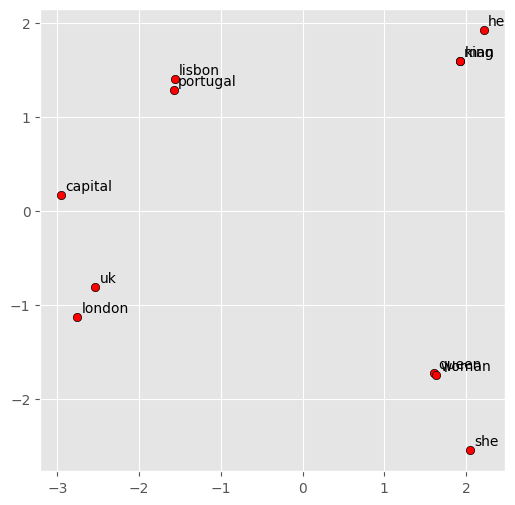

In [6]:
display_scatterplot(w2v.detach().numpy(), vocabulary)


In [7]:
w2v

tensor([[-2.3283,  0.1902,  0.9486,  2.1130],
        [-1.5153,  0.2905,  0.9390,  1.4807],
        [-1.5504,  0.3291,  0.9823,  1.4666],
        [ 1.3544,  2.2290, -0.2954,  1.0487],
        [ 1.2120,  1.7463, -0.2795,  1.0814],
        [ 1.2242,  1.7668, -0.2244,  1.0485],
        [-0.5817, -2.4425,  0.3142, -1.8113],
        [-0.2561, -2.2531,  0.2429, -1.6303],
        [ 0.3048, -2.1887, -0.8070, -1.9838],
        [ 0.4973, -0.0424, -1.3169, -1.9550],
        [ 1.2849, -1.0187, -1.0331, -1.0157]], grad_fn=<DivBackward0>)

# Pre-trained Word Embeddings

In [8]:
%pip install gensim

import gensim.downloader as api
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load Word2Vec trained on Google News data
wv = api.load('word2vec-google-news-300')

Note: you may need to restart the kernel to use updated packages.
[========================--------------------------] 48.5% 806.6/1662.8MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 845791232 out of 1743563840 bytes>

## Word Vectors

In [ ]:
# Import NumPy
import numpy as np

# Import PCA from scikit-learn
from sklearn.decomposition import PCA

# Import PCA from scikit-learn
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# Import Gensim for the word embeddings
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

for i, word in enumerate(wv.key_to_index):
    if i == 10:
        break
    print(word)


In [ ]:
vec_king = wv['king']
print(vec_king)

## Words Similarity

In [ ]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

In [ ]:
print(wv.most_similar(positive=['car', 'batman'], topn=5))

## Word Analogies


In [ ]:
def analogy(x1, x2, y1):
    result = wv.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy('japan', 'japanese', 'brazil')

In [ ]:
analogy('queen', 'king', 'woman')

In [ ]:
analogy('good', 'fantastic', 'bad')

## Visualization

In [ ]:
def display_pca_scatterplot(model, words):

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
        
def display_closestwords(model, word):
    
    # get close words
    a = model.similar_by_word(word)
    close_words = [w for (w,s) in a]
    close_words.append(word)
    display_pca_scatterplot(model, close_words)


In [ ]:
display_pca_scatterplot(wv, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'france', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

In [ ]:
a = display_closestwords(wv, 'plane')

## More

 - Word Embeddings for noisy text https://fasttext.cc/docs/en/english-vectors.html


 - Diachronic Word Embeddings https://nlp.stanford.edu/projects/histwords/


 - Sentence Embeddings https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
